In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data from [Kaggle](https://inclass.kaggle.com/c/comet-track-recognition-mlhep-2015/data) is already here in the "data" folder. Let's take a look at it.

In [2]:
! pwd

/home/santipov/data/projects/mlhep


In [3]:
hits_train = pd.read_csv("mlhep2015_starterkit/data/train.csv", index_col='global_id')
hits_train.head()

,event_id,wire_id,energy_deposit,relative_time,label
global_id,,,,,
0,0,0,0.000000e+00,0.000000,0
1,0,1,0.000000e+00,0.000000,0
2,0,2,0.000000e+00,0.000000,0
3,0,3,0.000000e+00,0.000000,0
4,0,4,1.178108e-08,22.224176,2


In [4]:
hits_test = pd.read_csv("mlhep2015_starterkit/data/test.csv", index_col='global_id')
hits_test.head()

,event_id,wire_id,energy_deposit,relative_time
global_id,,,,
7619400,1700,0,0.000000,0.000000
7619401,1700,1,0.000000,0.000000
7619402,1700,2,0.000000,0.000000
7619403,1700,3,0.000061,515.932708
7619404,1700,4,0.000000,0.000000


# Naive manual analysis
Obviously a not-so-good algorithm, used primaraly for illustrating IPython

First, check whether a a signal wire can have energy_deposit = 0

In [4]:
set(hits_train.loc[(hits_train.energy_deposit == 0)].label)

It can't! So far so good.

In [5]:
candidates = hits_train.loc[(hits_train.energy_deposit > 0)]

Try plotting time vs. energy vs. label. It's too big, so we'll take a sample. 

In [6]:
plot_sample_indices = np.random.choice(np.arange(len(candidates)), size=50000)
hits_to_plot = candidates.iloc[plot_sample_indices]

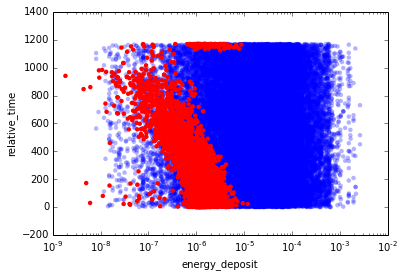

In [7]:
fig, ax = plt.subplots()
signal_hits = hits_to_plot.loc[(hits_to_plot.label == 1)]
noise_hits = hits_to_plot.loc[(hits_to_plot.label == 2)]
ax.scatter(noise_hits.energy_deposit, noise_hits.relative_time, c='b', edgecolors='none', alpha=0.3)
ax.scatter(signal_hits.energy_deposit, signal_hits.relative_time, c='r', edgecolors='none')
ax.set_xscale('log')
ax.set_xlim(1e-9, 1e-2)
ax.set_xlabel("energy_deposit")
ax.set_ylabel("relative_time")

Looks like we could use a selection rule.

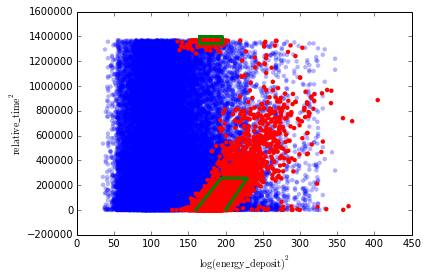

In [8]:
fig, ax = plt.subplots()
ax.scatter(np.log(noise_hits.energy_deposit)**2, noise_hits.relative_time**2, c='b', edgecolors='none', alpha=0.3)
ax.scatter(np.log(signal_hits.energy_deposit)**2, signal_hits.relative_time**2, c='r', edgecolors='none')
high_relative_time = 1.35e6
low_relative_time = 256300
low_points = np.array([[160, 0], [194, low_relative_time], [229, low_relative_time], [200, 0]])
high_points = np.array([[164, 1.4e6], [195, 1.4e6], [195, high_relative_time], [164, high_relative_time],
                        [164, 1.4e6]])
ax.plot(low_points[:, 0], low_points[:, 1], 'g', lw=3)
ax.plot(high_points[:, 0], high_points[:, 1], 'g', lw=3)
ax.set_xlabel(r"$\log(\mathrm{energy\_deposit})^2$")
ax.set_ylabel(r"$\mathrm{relative\_time}^2$")

In [9]:
top_line_coeffs = np.polyfit(low_points[0:2, 0], low_points[0:2, 1], deg=1)
bottom_line_coeffs = np.polyfit(low_points[2:4, 0], low_points[2:4, 1], deg=1)
def is_signal(event):
    log_energy_squared = np.log(event.energy_deposit)**2
    relative_time_squared = event.relative_time**2
    return (((relative_time_squared < low_relative_time) & (
            relative_time_squared < np.poly1d(top_line_coeffs)(log_energy_squared)) & (
                relative_time_squared > np.poly1d(bottom_line_coeffs)(log_energy_squared))) | 
            ((relative_time_squared > high_relative_time) & 
             (log_energy_squared > 164) & (log_energy_squared < 195)))

Also, np.log(0) is -inf. And it is correcly handled.

In [10]:
np.log(0)

-inf

In [11]:
hits_train.iloc[1]

event_id          0
wire_id           1
energy_deposit    0
relative_time     0
label             0
Name: 1, dtype: float64

In [12]:
is_signal(hits_train.iloc[1])

False

Check how good the model describes the data.

In [13]:
from sklearn.metrics import roc_auc_score
hits_train_is_signal = (hits_train.label == 1)
roc_auc_score(hits_train_is_signal, is_signal(hits_train))

0.88085694017473237

Let's make a predicion for submission. Take note at the format: only the events with positive energy.

In [14]:
prediction = pd.DataFrame({"prediction": is_signal(hits_test.loc[hits_test.energy_deposit > 0]).astype(np.int)})

In [15]:
prediction.to_csv("naive_manual_prediction.csv", index_label='global_id')

Download your predictions from the cluster.

In [16]:
from IPython.display import FileLink
FileLink("naive_manual_prediction.csv")

naive_manual_prediction.csv

# Naive machine learning

In [17]:
from sklearn.tree import DecisionTreeClassifier

CV might take some time

In [18]:
from sklearn.cross_validation import cross_val_score
cv_gini = cross_val_score(DecisionTreeClassifier(criterion='gini'),
                hits_train[['energy_deposit', 'relative_time']].values, (hits_train.label == 1).values.astype(np.int),
               scoring='roc_auc')
print(cv_gini.mean(), cv_gini.std())

(0.81314743310192517, 0.0013793144626458457)


In [19]:
cv_entropy = cross_val_score(DecisionTreeClassifier(criterion='entropy'),
                hits_train[['energy_deposit', 'relative_time']].values, (hits_train.label == 1).values.astype(np.int),
                scoring='roc_auc')
print(cv_entropy.mean(), cv_entropy.std())

(0.81018610084350995, 0.0013386535360269877)


In [20]:
classifier = DecisionTreeClassifier(criterion='gini')
classifier.fit(hits_train[['energy_deposit', 'relative_time']], (hits_train.label == 1))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [21]:
candidates = hits_test.loc[hits_test.energy_deposit > 0]
ml_prediction = pd.DataFrame({
        "prediction": classifier.predict_proba(candidates[[
                    'energy_deposit', 'relative_time']])[:, 1]}, index=candidates.index)

In [22]:
ml_prediction.to_csv("naive_ml_prediction.csv", index_label='global_id')

Moral: sometimes you can outdo simple machine learning by thinking. Corollary: the best result is achieved by combining the approaches.

In [23]:
FileLink("naive_ml_prediction.csv")

naive_ml_prediction.csv

In [44]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rf_classifier = RandomForestClassifier(criterion='entropy')

In [45]:
rf_classifier.fit(hits_train[['energy_deposit', 'relative_time']], (hits_train.label == 1))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
rf_candidates = hits_test.loc[hits_test.energy_deposit > 0]
rf_ml_prediction = pd.DataFrame({
        "prediction": rf_classifier.predict_proba(rf_candidates[[
                    'energy_deposit', 'relative_time']])[:, 1]}, index=rf_candidates.index)

In [47]:
rf_ml_prediction.to_csv("rf_ml_prediction.csv", index_label='global_id')

In [48]:
FileLink("rf_ml_prediction.csv")

rf_ml_prediction.csv